# Advantage Actor Critic (A2C)

#### Autores:
- Celia Quiles Aleman - 202315604@alu.comillas.edu
 - Álvaro Ezquerro Pérez - alvaroezquerro@alu.comillas.edu
 - María Calvo de Mora Román - 202320059@alu.comillas.edu

#### Desarrollado por:
Celia Quiles Alemañ

## Introducción al algoritmo A2C

El algoritmo A2C (Advantage Actor-Critic) es una técnica de aprendizaje por refuerzo que combina los enfoques de Actor y Crítico para entrenar agentes en diversos entornos. 

1. **Actor**:

El Actor es la red responsable de aprender y mejorar la política de acciones del agente. 
Esta política de acciones determina qué acciones debe tomar el agente en función del estado actual del entorno.
El Actor utiliza métodos de optimización, como el gradiente ascendente, para ajustar los parámetros de la política y maximizar la recompensa esperada.

2. **Crítico**:

El Crítico es responsable de estimar los valores de los estados del entorno. Estos valores de estado representan cuán "bueno" es un estado en términos de las recompensas futuras esperadas.
El Crítico proporciona una señal de retroalimentación que ayuda al Actor a mejorar su política. 

A2C destaca frente a otros algoritmos de RL en cuanto a que consigue aprender simultáneamente la política y los valores de estado en un mismo algoritmo.

En este trabajo, el algoritmo A2C se implementará y probará en el juego del BlackJack para entrenar un agente capaz de jugar de manera óptima.

## Introducción al environment BlackJack

A continuación se detallan las especificaciones del entorno que nuestro agente enfrentará, basadas en la documentación proporcionada.

##### Acciones:

El espacio de acción en el entorno de Blackjack incluye dos posibles acciones:
- **Pegar (Hit, acción=1)**: El jugador solicita otra carta para intentar acercarse más a un total de 21 sin pasarse.
- **Quedarse (Stand, acción=0)**: El jugador decide no recibir más cartas, terminando su turno.


##### Estado:

El agente observa el estado del juego a través de una tupla que contiene:
- La suma actual de las cartas del jugador.
- El valor de la carta visible del crupier (1-10, donde 1 es un as).
- Un indicador de si el jugador tiene un as utilizable (0 o 1).

##### Recompensas:
Las recompensas se asignan como sigue:
- Ganar la partida: +1
- Perder la partida: -1
- Empate: 0
- Ganar con un blackjack natural:
    - +1.5 si la opción 'natural' está activada y se gana con un blackjack natural.
    - +1 si la opción 'natural' está desactivada o no se gana con un blackjack natural.
El objetivo es maximizar la suma total de recompensas, lo que implica gestionar de manera efectiva el riesgo y la oportunidad de tomar cartas adicionales para acercarse a un total de 21.

##### Terminación del Episodio:
El episodio termina cuando el jugador se pasa de 21 (bust), después de que el jugador se queda y el crupier juega su mano, o cuando el jugador obtiene un blackjack natural, dependiendo de las reglas específicas configuradas en el entorno.

Utilizaremos la versión 'Blackjack-v1' del entorno, que está diseñada para reflejar la versión del juego de blackjack descrita en el libro "Reinforcement Learning: An Introduction" por Sutton y Barto. Además, emplearemos las opciones por defecto del entorno es decir con la opción 'natural' desactivada.


## Código

#### Importación de librerías

In [1]:
import tensorflow as tf
import numpy as np
import gym
import math
from PIL import Image
import pygame, sys
from pygame.locals import *
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, concatenate
import math
import matplotlib.pyplot as plt
from collections import deque

from tqdm import tqdm
from src.utils.plotting import plot_blackjack_performance

2024-05-13 17:39:46.901643: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Creación del entorno

En primer lugar, necesitamos definir el entorno de gym a usar, así como el espacio de observación y las posibles acciones a realizar. 
En nuestro caso, creamos el entorno de Blackjack-v1 de gym.

Paralelamente, para que todas las pruebas sean consistentes y reproducibles, hemos fijado semillas para que todos los procesos aleatorios siempre produzcan el mismo resultado.


In [2]:
# Establecemos semillas para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Creamos el entorno
env = gym.make("Blackjack-v1", render_mode="human")
input_shape = len(env.observation_space)
num_acciones = env.action_space.n

#### Especificación de las redes neuronales


A continuación, definimos cada una de las capas que forman nuestras dos redes neuronales: la del Actor y la del Crítico.

1) Primero, ambas redes tienen una capa de entrada que recibe el estado del entorno en ese momento.

2) En segundo lugar, ambas redes tendrán dos capas ocultas con 32 neuronas. A ambas capas les introducimos una función de activación ReLU para introducir no linealidades en la red. 

3) Finalmente, definimos las capas de salida. **Aquí es donde se diferencian ambas redes**.
    - La red del Actor (que calcula las probabilidades de acción), tendrá en consecuencia en la capa densa una función de activación softmax (devolverá, para cada acción posible del estado correspondiente, una probabilidad).
    - La capa de salida de la red del crítico (que calcula los valores de acción), es una capa densa sin función de activación, la salida es un número "flotante", es decir, con decimal.


Para actualizar los pesos, elegimos el optimizer Adam, el cual combina el descenso de gradiente estocástico (SGD) y el método de adaptación de momentos.

In [3]:
# 1) Capa de entrada (tanto para Actor como para Crítico)
inputs = Input(shape=(input_shape,))

# 2) Capas ocultas (tanto para Actor como para Crítico)
hidden1 = Dense(32, activation='relu')(inputs)
hidden2 = Dense(32, activation='relu')(hidden1)

# 3) Capas de salida (diferentes para Actor y Crítico)
output1 = Dense(num_acciones)(hidden2)  # para el crítico
output2 = Dense(num_acciones, activation='softmax')(hidden2)  # para el actor con softmax

model = tf.keras.Model(inputs=inputs, outputs=[output2, output1])  # modelo con las capas definidas
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)   # usamos Adam como el optimizer (con lo que vamos estimando los pesos)

Antes de pasar al entrenamiento, también definimos algunas variables que son necesarias durante el entrenamiento:

- num_plays: cantidad de jugadas que haremos para entrenar nuestro modelo (num de iteraciones).

- gamma (factor de descuento): determina la importancia de las recompensas futuras en relación con las recompensas inmediatas, si gamma = 1 valoramos igual una recompensa futura que una recompensa inmediata, cuanto menor sea, más valoramos la recompensa inmediata.

- contador: contador que usaremos en las iteraciones (por eso lo inicializamos a 0, pues no hemos iterado ninguna vez).

- min_loss: valor de pérdida mínima observada, la iremos actualizando con valores menores. Por eso, la inicializamos con infinito, para que siempre se actualice al inicio. 

- maxlen: cantidad máxima a guardar en memoria en cuanto a estados, acciones, recompensas, próximos estados y "done"s.

- states, actions, rewards, next_states, dones: colas = deques que utilizaremos para almacenar los estados, acciones, recompensas, próximos estados y señales de terminación de los episodios más recientes.


Con las últimas variables usamos **deque(maxlen = 5)**.
Al usar deque con un tamaño máximo (maxlen = 5), garantizamos que la cola se mantenga dentro de un límite fijo, eliminando automáticamente los elementos más antiguos cuando se agrega un nuevo elemento y alcanza su tamaño máximo. Esto nos permite mantener un historial reciente de los elementos sin preocuparnos por el uso excesivo de memoria.

In [4]:

num_plays = 500
gamma = tf.cast(tf.constant(0.9),tf.float64)
contador = 0
n = 5 
min_loss = math.inf

maxlen = n
states = deque(maxlen = maxlen)
actions = deque(maxlen = maxlen)
rewards = deque(maxlen = maxlen)
next_states = deque(maxlen = maxlen)
dones = deque(maxlen = maxlen)

### Entrenamiento del algoritmo A2C

Como se explica dentro del código, diferencio 2 partes en cada jugada: 

**1) La primera parte, se corresponde con el Actor:**

El actor recibe el estado, y se predicen las probabilidades de seleccionar cada una de las acciones posibles para ese estado.
Se selecciona aleatoriamente una acción (atendiendo a las probabilidades de cada una de ellas), la cual se ejecuta y nos devuelve un nuevo estado, una recompensa e información sobre si se ha temrinado la partida.
Finalmente en esta parte, almacenamos esto recién obtenido para utilizarlo en la actualizacion de los pesos de la red.

**2) La segunda parte, se corresponde con el Crítico:**

En esta segunda parte, vamos a proceder a evaluar las acciones implementadas, y en base a esto, actualizaremos los pesos de las redes (se realiza cada n partidas, en nuetsro caso n = 5).

Así pues, cada n partidas, convertimos todo lo almacenado a tensores para obtener los gradientes de la "loss" en función de los parámetros del modelo. Entonces se ejecuta el modelo (tanto el actor como el crítico) para obtener las probabilidades de acción y los valores Q del estado actual (q_value1) y siguiente (q_value2).
Se calcula la ventaja (advantage) como la diferencia entre el valor objetivo y el valor predicho.
Se calcula la pérdida total como la combinación de la pérdida de política (logaritmo de las probabilidades de acción ponderado por la ventaja) y la pérdida de valor.
Se calculan los gradientes de la pérdida con respecto a los parámetros del modelo utilizando la cinta de gradiente.
Se utilizan los gradientes para actualizar los pesos del modelo utilizando el optimizador Adam.

Así vamos actualizando los pesos de las 2 redes y con el paso de las iteraciones, cada uno va mejorando su rendiemiento al mismo tiempo, pero de manera independiente.

In [5]:
# Repetimos el proceso tantas veces como episodios definidos

for episode in range(num_plays):

# ----------------------------------- 1ª parte: Actor ---------------------------------------------
# En primer lugar, reiniciamos el environment para comenzar con el estado inicial cada vez.
# Ejecutamos la partida, donde se selecciona la acción basándonos en la política actual.
# Va ejecutando las acciones, observa el siguiente estado y la recompensa resultante.
# Cuando el environment devuelve done = True, termina la partida.
# -------------------------------------------------------------------------------------------------

    state = list(list(env.reset())[0])
    state[2] = 1 if state[2] else 0

    # Ejecutamos la partida
    while True:
        contador = contador + 1
        # Cogemos las probailidades d ecada acción de acuerdo a la red de la política 
        action_probs, _ = model.predict(np.array([state]),verbose=0)

        # La acción se escoge aleatoriamente PERO de manera ponderada (tiene más probabilidad de ser escogida la de mayor prob en la política)
        action = np.random.choice(num_acciones, p=action_probs[0])

        # Hacemos la acción seleccionada y obtenemos resultados 
        next_state, reward, done, _ , _ = env.step(action)
        next_state = list(next_state)
        next_state[2] = 1 if next_state[2] else 0
        # Guardamos resultados recién obtenidos
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        next_states.append(next_state)
        dones.append(1 if done else 0)

        state = next_state

        # Si se ha terminado el env (done = True), se termina el entrenamiento
        if done:
            done=False
            break


# ----------------------------------- 2ª parte: Crítico ---------------------------------------------
# Cada n pasos, en nuestro caso, 5 jugadas, se realiza una actualización del modelo.
# 1º se convierten las listas de estados, acciones y recompensas en tensores.
# 2º ya con todo como tensores, se calculan los gradientes de la pérdida con respecto a los parámetros del modelo
# 3º (Cálculo de los q values actual y siguiente, target value, value loss, advantage, loss total...)
# 4º se optimizan los pesos usando Adam
# 5º si la pérdida actual es menor que la mínima pérdida registrada hasta ahora, se guarda el modelo 
# --------------------------------------------------------------------------------------------------

    if contador > n:
            contador = 0
            # Todas las listas pasan a ser tensores para poder obtener gradientes
            states_ = tf.convert_to_tensor(states)
            actions_ = tf.convert_to_tensor(actions)
            rewards_ = tf.convert_to_tensor(rewards)
            next_states_ = tf.convert_to_tensor(next_states)

            # Se obtienen gradientes, se aplican y se actualizan pesos
            with tf.GradientTape(persistent=True) as tape:
       
                action_probs,q_values1 = model(states_)
                q_value1 = tf.cast(tf.gather(q_values1,actions_,axis=1,batch_dims=1),tf.float64)
                _,q_value2 = model(next_states_)
                q_value2 = tf.cast(tf.reduce_max(q_value2),tf.float64)
                
                target_value = tf.cast(rewards_,tf.float64) + (tf.cast(1,tf.float64)-tf.cast(dones,tf.float64))*gamma*q_value2
                value_loss = tf.reduce_mean(tf.math.pow(target_value-q_value1,2))
                advantage = target_value - q_value1
      
                action_probs = tf.cast(tf.math.log(tf.gather(action_probs,actions,axis=1,batch_dims=1)),tf.float64)
                loss = -tf.reduce_mean(action_probs * advantage) + value_loss


            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

    
        # Salida por pantalla (cada n = 5 jugadas)
            print(f'Iteración {episode} con pérdida {loss}')
            if loss < min_loss:
                min_loss = loss
                #model.save('models/A2C.keras')

/opt/anaconda3/envs/ML2/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Iteración 4 con pérdida 4.352695616104916
Iteración 9 con pérdida 3.1131417045052268
Iteración 12 con pérdida 1.808808982098388
Iteración 15 con pérdida 0.6844987950680694
Iteración 19 con pérdida 0.34085700127094043
Iteración 22 con pérdida 0.305737639425316
Iteración 26 con pérdida 8.096691682771691
Iteración 28 con pérdida 0.11101106702695489
Iteración 33 con pérdida 1.684834160977069
Iteración 36 con pérdida 0.30863074674902424
Iteración 40 con pérdida 5.387748826748512
Iteración 43 con pérdida 2.670664250652541
Iteración 47 con pérdida 0.5100195166149177
Iteración 52 con pérdida 1.6012516466913245
Iteración 56 con pérdida 0.7198826934845095
Iteración 62 con pérdida 2.979262216685437
Iteración 68 con pérdida 1.768834463244854
Iteración 74 con pérdida 1.6930165896188927
Iteración 78 con pérdida 0.19832999309887128
Iteración 82 con pérdida 1.1710312108312684
Iteración 88 con pérdida 0.5567203323699161
Iteración 93 con pérdida 1.675654418706768
Iteración 99 con pérdida 0.3608878267014

Como se aprecia en la salida por pantalla, a más iteraciones, el error va disminuyendo.

Comenzamos en las primeras iteraciones con una loss total de en torno a 10 unidades, y vamos disminuyendo de manera gradual hasta alcanzar pérdidas menores de 0,5.

### Evaluación del modelo

A continuación, definimos 2 funciones que vamos a emplear para evaluar el algoritmo A2C que se ha obtenido.
Una de ellas, "evaluacion_modelo_a2c" va a repetir la lógica del entrenamiento, pero sin la parte de actualización de los modelos, para ver cómo se comportaría el modelo obtenido ante 1000 partidas nuevas.

Finalmente, para representar los resultados de manera visual, usamos "plot_results".

In [6]:
def evaluacion_modelo_a2c(env, model, n_episodes):
    """Evalúa el modelo A2C en un número dado de episodios utilizando la misma lógica de toma de decisiones que durante el entrenamiento.
    Args:
        env: El entorno de Gym.
        model: El modelo A2C.
        n_episodes: El número de episodios para evaluar.
    Returns:
        Un conjunto de métricas de evaluación.
    """
    total_rewards = 0
    total_penalties = 0
    total_steps = 0
    wins = 0

    for episode in range(n_episodes):
        state = env.reset()
        state = np.array(state[0])
        episode_rewards = 0
        done = False

        while not done:
            # Seleccionamos acción basada en la política aprendida
            action_probs, _ = model.predict(np.array([state]))
            action = np.argmax(action_probs[0])  # Seleccionar la acción con mayor probabilidad

            # Ejecutamos esa acción
            next_state, reward, done, info, _ = env.step(action)  # obtenemos siguiente estado, recompensa y si ha terminado
            episode_rewards += reward
            total_steps += 1

            # Actualizamos el estado
            state = np.array(next_state)

            if reward == -1:
                total_penalties += 1
            elif reward > 0:
                wins += 1

        total_rewards += episode_rewards

    win_rate = wins / n_episodes

    return win_rate, total_rewards, total_penalties, total_steps

def plot_results(win_rate, total_rewards, total_penalties, total_steps, title):
    """Función que muestra los resultados obtenidos en forma de gráfico de barras.
    Args:
        win_rate: Tasa de victorias del agente.
        total_rewards: Recompensa total alcanzada en el entrenamiento.
        total_penalties: Penalización total alcanzada en el entrenamiento.
        total_steps: Número total de pasos alcanzados durante el entrenamiento.
        title: Título del gráfico.
    """

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    categories = ['Tasa de Victorias', 'Recompensas Totales', 'Penalizaciones Totales', 'Pasos Totales']
    values = [win_rate, total_rewards, total_penalties, total_steps]
    colors = ['gold', 'blue', 'red', 'green']
    bars = ax.bar(categories, values, color=colors)
    
    ax.set_ylabel('Valores')
    ax.set_title(title)
    
    for bar in bars:
        yval = bar.get_height()
        #position = yval - 0.05 if yval < 0 else yval + 0.05
        position = 20
        ax.text(bar.get_x() + bar.get_width()/2.0, position, round(yval, 2), va='center', ha='center')
    
    plt.tight_layout()
    plt.show()


In [7]:
# Usamos la función de evaluación ante 1000 jugadas nuevas
win_rate, total_rewards, total_penalties, total_steps = evaluacion_modelo_a2c(env, model, n_episodes=1000)

# Mostramos los resultados en un gráfico de barras
print("Tasa de Victorias:", win_rate)
print("Recompensas Totales:", total_rewards)
print("Penalizaciones Totales:", total_penalties)
print("Pasos Totales:", total_steps)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

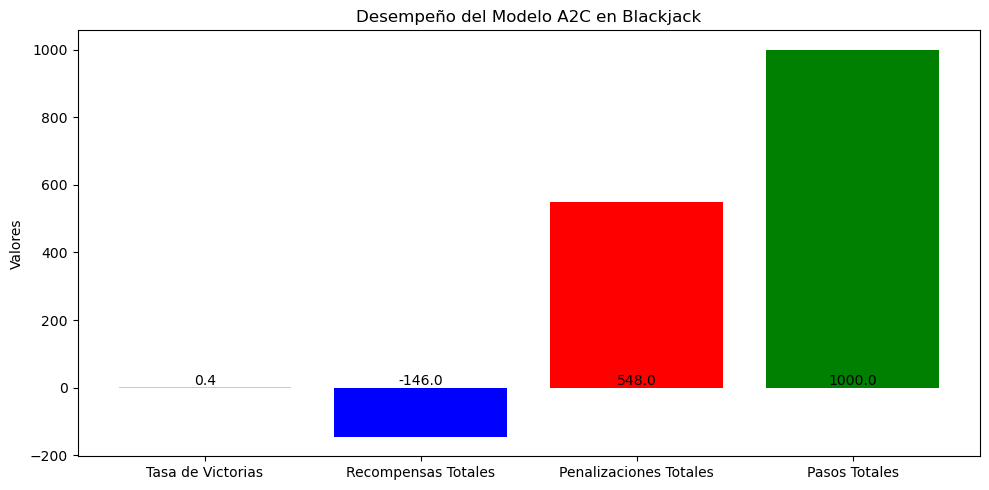

In [8]:
# Mostrar los resultados en un gráfico
title = 'Desempeño del Modelo A2C en Blackjack'
plot_results(win_rate, total_rewards, total_penalties, total_steps, title)

Hemos decidido representar 4 barras, cada una de ellas relativa a cada una de las métricas.

- En cuanto a la tasa de victorias (% de victorias), se obtiene un 40,5%. Es decir, he han ganado 405 de las 1000 nuevas partidas.
- En total, se ha obtenido una recompensa de -136 unidades.
- En cuanto a las penalizaciones, estas han sido de hasta 541 entre las 1000 partidas.
- Y, finalmente, aparecen en verde las 1000 partidas que se han jugado.


In [9]:
def evaluate_a2c_agent(env, model, num_episodes):
    total_rewards = []
    total_steps = 0

    
    for episode in range(num_episodes):
        state = env.reset()
        state = np.array(state[0])
        episode_reward = 0
        episode_steps = 0
        done = False


        while not done:
            # Seleccionamos acción basada en la política aprendida
            action_probs, _ = model.predict(np.array([state]))
            action = np.argmax(action_probs[0])  # Seleccionar la acción con mayor probabilidad

            # Ejecutamos esa acción
            next_state, reward, done, info, _ = env.step(action)  # obtenemos siguiente estado, recompensa y si ha terminado
            episode_reward += reward
            episode_steps += 1

            # Actualizamos el estado
            state = np.array(next_state)


        total_rewards.append(episode_reward) 
        total_steps += episode_steps

    avg_reward = sum(total_rewards) / num_episodes
    avg_episode_length = total_steps / num_episodes

    return avg_reward, avg_episode_length, total_rewards

# Example usage:
avg_reward, avg_episode_length, total_rewards= evaluate_a2c_agent(env, model, num_episodes=500)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

Average reward: -0.144, Average episode length: 1.0


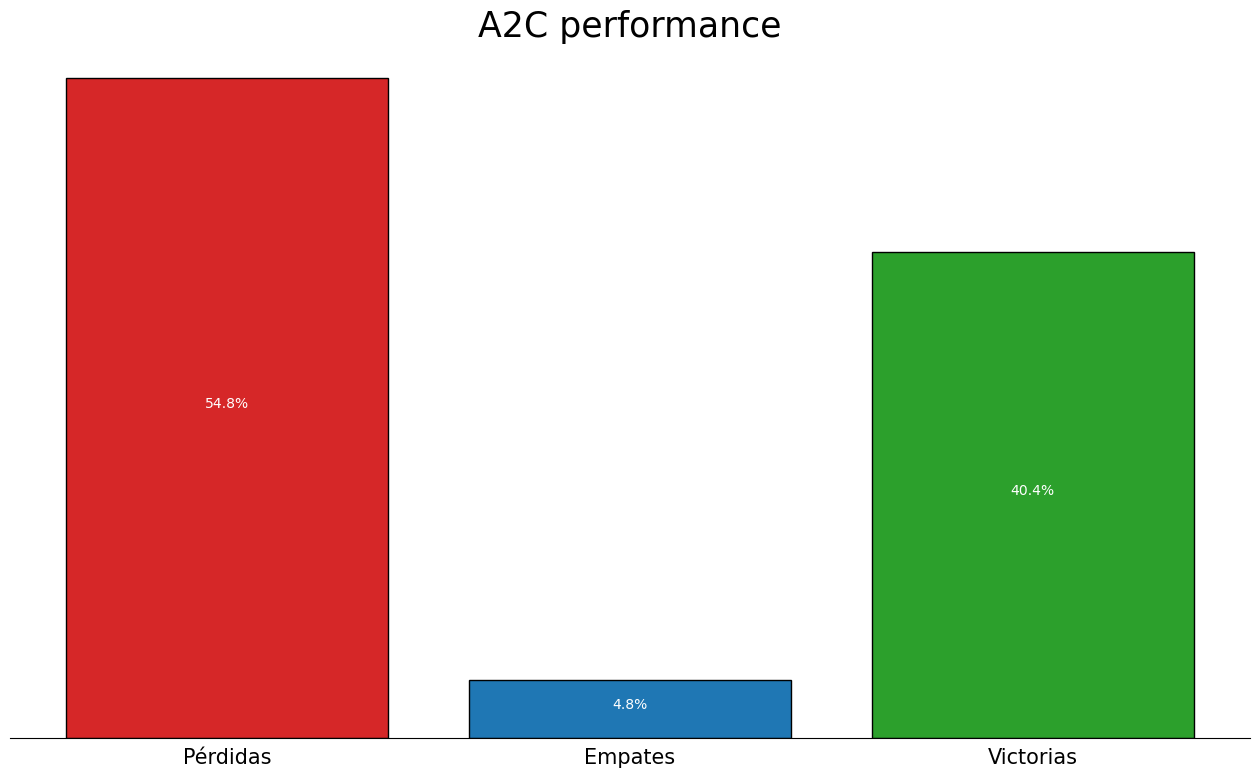

In [10]:
print(f"Average reward: {avg_reward}, Average episode length: {avg_episode_length}")
plot_blackjack_performance(total_rewards, "A2C performance")